## 1. _Pre-processing_

https://www.openml.org/d/35

In [1]:
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

In [2]:
dermatology = pd.read_csv('dataset_35_dermatology.csv')
dermatology.head()

,erythema,scaling,definite_borders,itching,koebner_phenomenon,polygonal_papules,follicular_papules,oral_mucosal_involvement,knee_and_elbow_involvement,scalp_involvement,...,disappearance_of_the_granular_layer,vacuolisation_and_damage_of_basal_layer,spongiosis,saw-tooth_appearance_of_retes,follicular_horn_plug,perifollicular_parakeratosis,inflammatory_monoluclear_inflitrate,band-like_infiltrate,Age,class
0,2,2,0,3,0,0,0,0,1,0,...,0,0,3,0,0,0,1,0,55,2
1,3,3,3,2,1,0,0,0,1,1,...,0,0,0,0,0,0,1,0,8,1
2,2,1,2,3,1,3,0,3,0,0,...,0,2,3,2,0,0,2,3,26,3
3,2,2,2,0,0,0,0,0,3,2,...,3,0,0,0,0,0,3,0,40,1
4,2,3,2,2,2,2,0,2,0,0,...,2,3,2,3,0,0,2,3,45,3


In [3]:
dermatology.shape

(366, 35)

In [4]:
dermatology.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 35 columns):
erythema                                    366 non-null int64
scaling                                     366 non-null int64
definite_borders                            366 non-null int64
itching                                     366 non-null int64
koebner_phenomenon                          366 non-null int64
polygonal_papules                           366 non-null int64
follicular_papules                          366 non-null int64
oral_mucosal_involvement                    366 non-null int64
knee_and_elbow_involvement                  366 non-null int64
scalp_involvement                           366 non-null int64
family_history                              366 non-null int64
melanin_incontinence                        366 non-null int64
eosinophils_in_the_infiltrate               366 non-null int64
PNL_infiltrate                              366 non-null int64
fibrosis_of_t

In [5]:
age = dermatology['Age']
age_provided = age.str.isnumeric()
age[~age_provided] = age[age_provided].median().astype(np.object)
dermatology['Age'] = age.astype(np.int64)

In [6]:
dermatology.dtypes.value_counts()

int64    35
dtype: int64

In [7]:
dermatology.columns[dermatology.isnull().sum() > 0]

Index([], dtype='object')

In [8]:
dermatology['class'].value_counts()

1    112
3     72
2     61
5     52
4     49
6     20
Name: class, dtype: int64

## 2. _Visualization_

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

In [11]:
X, y = dermatology.drop('class', 1), dermatology['class']

for col in X.columns:
    X[col] = StandardScaler().fit_transform(X[[col]])

print(X.shape, y.shape)

(366, 34) (366,)


### 2.1 _t-SNE_

In [12]:
X_embedded = TSNE(n_components=2).fit_transform(X)

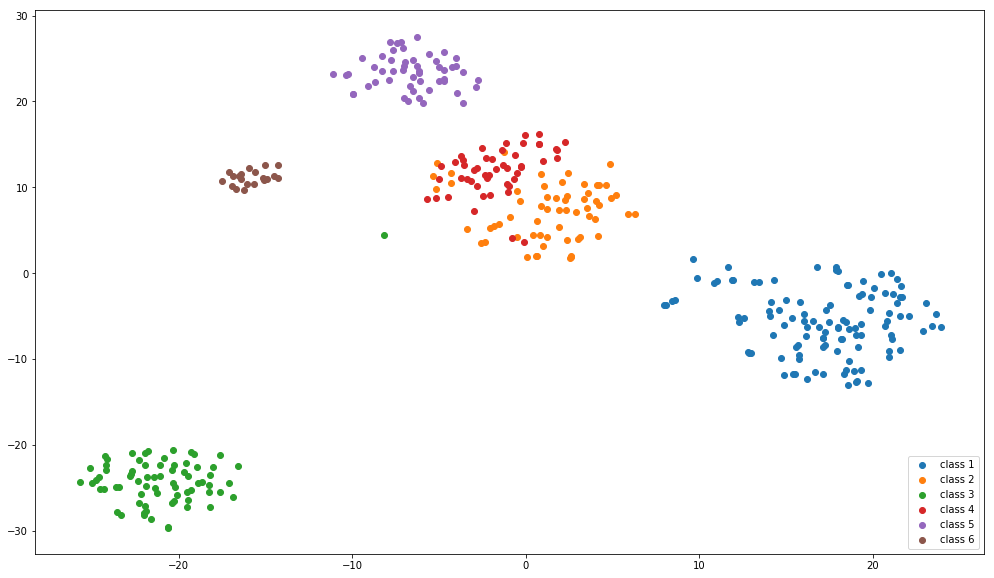

In [13]:
plt.figure(figsize=(17,10))

for u in sorted(y.unique()):
    ix = np.argwhere(y == u).squeeze()
    plt.scatter(X_embedded[ix, 0], X_embedded[ix, 1], label='class {}'.format(u))

plt.legend(loc=4);

### 2.1 _PCA_ 

In [14]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

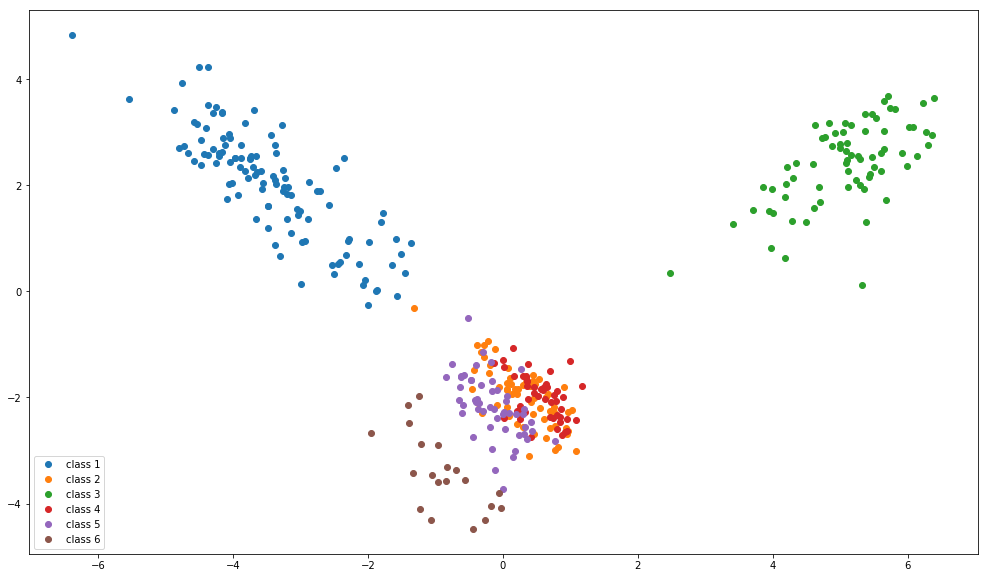

In [15]:
plt.figure(figsize=(17,10))

for u in sorted(y.unique()):
    ix = np.argwhere(y == u).squeeze()
    plt.plot(X_pca[ix, 0], X_pca[ix, 1], 'o', label='class {}'.format(u))

plt.legend();

In [16]:
for i, component in enumerate(pca.components_):
    print("Component #{}: {:.2f}% of initial variance".format(i + 1, 100 * pca.explained_variance_ratio_[i], 2))

Component #1: 27.18% of initial variance
Component #2: 16.13% of initial variance


## 3. _Linear models_

In [17]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [18]:
X_emb_train, X_emb_test, X_train, X_test, y_train, y_test = train_test_split(X_embedded, X, y, train_size=0.8)

### 3.1 _Logistic Regression_ 

In [19]:
clf = Pipeline([
            ('scaler', StandardScaler()), 
            ('regressor', LogisticRegressionCV(Cs=[0.1, 0.5, 1.0, 10., 100.], scoring='r2', cv=5))
        ])

clf.fit(X_train, y_train);

In [20]:
y_pred = clf.predict(X_test)

print('[LogR] R2 for best (test): {:.5f}'.format(r2_score(y_pred, y_test)))
print('*' * 40)

[LogR] R2 for best (test): 0.94802
****************************************


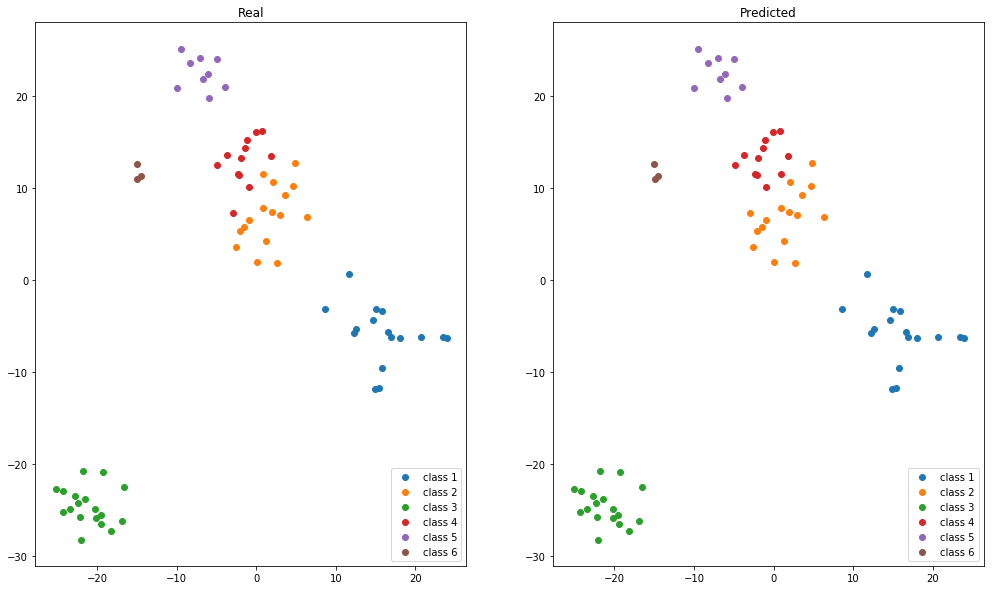

In [21]:
def plot_real_vs_predicted(X, y_test, y_pred):
    plt.figure(figsize=(17,10))
    
    def subplot(nrc, title, X, y):
        plt.subplot(nrc)
        plt.title(title)
        for u in sorted(np.unique(y)):
            ix = np.argwhere(y == u).squeeze()
            plt.scatter(X[ix, 0], X[ix, 1], label='class {}'.format(u))
        plt.legend(loc=4)
        
    subplot(121, 'Real', X_emb_test, y_test)
    subplot(122, 'Predicted', X_emb_test, y_pred)
    
plot_real_vs_predicted(X_emb_test, y_test, y_pred);

### 3.2 _SVM_

In [22]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [23]:
clf = Pipeline([
            ('scaler', StandardScaler()), 
            ('regressor', SVC())
        ])

svc_grid_params = {
    'regressor__C' : [0.1, 0.5, 1.0, 10., 100.],
    'regressor__kernel' : ['linear', 'rbf']
}

gs = GridSearchCV(clf, svc_grid_params, scoring='r2', cv=5)
gs.fit(X_train, y_train)

gs.best_estimator_.steps[1][1]

SVC(C=10.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [24]:
y_pred = gs.best_estimator_.predict(X_test)

print('[SVC] R2 for best (train): {:.5f}'.format(gs.best_score_))
print('[SVC] R2 for best (test): {:.5f}'.format(r2_score(y_pred, y_test)))
print('*' * 40)

[SVC] R2 for best (train): 0.96230
[SVC] R2 for best (test): 0.94802
****************************************


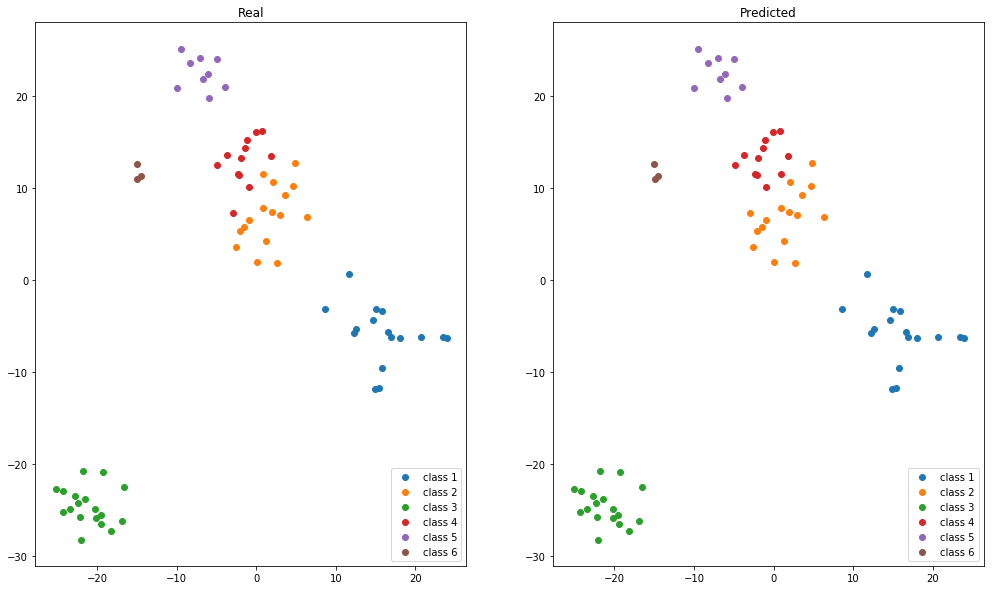

In [25]:
plot_real_vs_predicted(X_emb_test, y_test, y_pred);

## 4.$^{*}$  _Compare with KNN_ 

In [26]:
from sklearn.neighbors import KNeighborsClassifier

In [27]:
clf = Pipeline([
            ('scaler', StandardScaler()), 
            ('regressor', KNeighborsClassifier())
        ])

knn_grid_params = {
    'regressor__n_neighbors': list(range(1,50,2)),
    'regressor__weights': ['uniform', 'distance', lambda x: 1./x**2],
    'regressor__algorithm': ['auto'],
    'regressor__leaf_size': [30],
    'regressor__metric': ['minkowski'],
    'regressor__p': [2]
}

gs = GridSearchCV(clf, knn_grid_params, scoring='r2', cv=5)
gs.fit(X_train, y_train)

gs.best_estimator_.steps[1][1]

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=21, p=2,
           weights='uniform')

In [28]:
y_pred = gs.best_estimator_.predict(X_test)

print('[KNN] R2 for best (train): {:.5f}'.format(gs.best_score_))
print('[KNN] R2 for best (test): {:.5f}'.format(r2_score(y_pred, y_test)))
print('*' * 40)

[KNN] R2 for best (train): 0.95452
[KNN] R2 for best (test): 0.97408
****************************************


_Если судить по `R2`, то видно, что линейные классификаторы с данной задачей справляются вполне хорошо, так что применять **KNN** особого смысла нет_.